In [72]:
import pandas as pd

In [73]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [74]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [75]:
df = df.fillna(0)


In [76]:
# Split data into train, validate and test using scikit learn

from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state =1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state =1)
len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

In [77]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [78]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [79]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [80]:
# Convert dataframes to matrices
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient = 'records')
dv = DictVectorizer(sparse = True)
X_Train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient = 'records')
X_val = dv.fit_transform(val_dicts)

In [81]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

In [82]:
# Training a decision tree regressor to predict the fuel_efficiency_mpg variable

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_Train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [83]:
# To check which feature is used for splitting the data
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [85]:
# Train a random forest regressor and calculate RMSE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Helper function for RMSE calculation
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_Train, y_train)

# Predict on validation data
y_pred_val = rf.predict(X_val)

# Calculate RMSE
rmse_ = rmse(y_val, y_pred_val)

print(f"Random Forest (n_estimators=10) Validation RMSE: {rmse_:.3f}")

Random Forest (n_estimators=10) Validation RMSE: 0.460


In [88]:
# let's experiment with the n_estimators parameter
scores = [] 
for n in range (10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_Train, y_train)

    y_pred_val = rf.predict(X_val)
    rmse_ = rmse(y_val, y_pred_val)
    scores.append((n,rmse_))

In [90]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [91]:
df_scores

,n_estimators,rmse
0,10,0.459578
1,20,0.453591
2,30,0.451687
3,40,0.448721
4,50,0.446657
5,60,0.445460
6,70,0.445126
7,80,0.444984
8,90,0.444861
9,100,0.444652


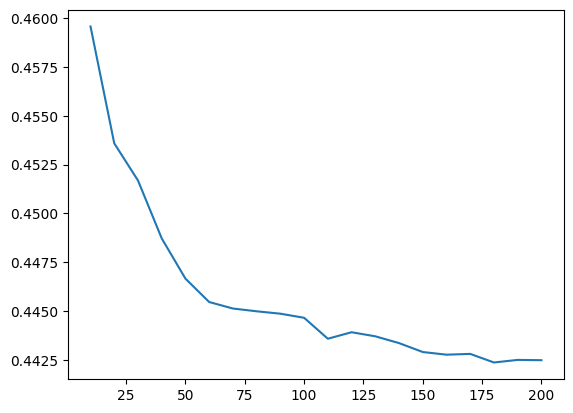

In [95]:
import matplotlib.pyplot as plt
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [ ]:
# let's experiment with the n_estimators parameter
max_depth = [10, 15, 20, 25]
scores = [] 
for depth in max_depth:
    for n in range (10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_Train, y_train)
        
        y_pred_val = rf.predict(X_val)
        rmse_ = rmse(y_val, y_pred_val)
        scores.append((depth, n, rmse_))

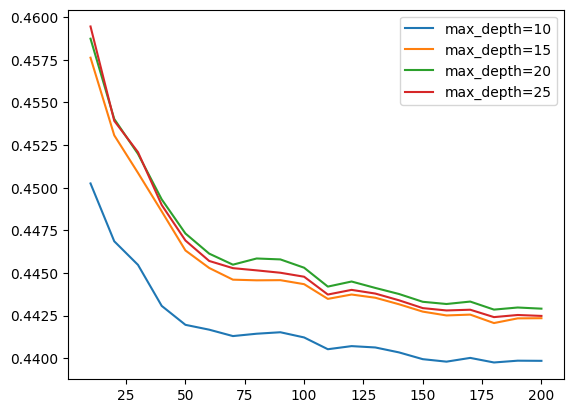

In [118]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators','rmse'])

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%s' %d)
plt.legend()

,max_depth,n_estimators,rmse
0,10,10,0.450249
1,10,20,0.446857
2,10,30,0.445474
3,10,40,0.443067
4,10,50,0.441957
...,...,...,...
75,25,160,0.442800
76,25,170,0.442843
77,25,180,0.442409
78,25,190,0.442534


In [105]:
# Find most important feature 

rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=20, 
    random_state=1, 
    n_jobs=-1
)
rf.fit(X_Train, y_train)

#  Extract feature importance
importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()

df_importances = pd.DataFrame({
    'feature': feature_names, 
    'importance': importances
}).sort_values(by='importance', ascending=False)



In [109]:
df_importances.head(1).iloc[0]

feature       vehicle_weight
importance           0.95915
Name: 13, dtype: object

In [110]:
# Gradient boosting and XGboost

!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 51.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 49.6 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [121]:
import xgboost as xgb

features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_Train, label=y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names = features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [144]:
scores = {}

In [150]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [134]:
def parse_xgb_output(output):
    res = []

    for line in output.stdout.strip().split('\n'):
        num_iter, train, val = line.split('\t')

        num_iter = int(num_iter.strip('[]'))
        train = float(train.split(':')[1])
        val = float(val.split(':')[1])

        res.append((num_iter, train, val))
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(res, columns=columns)
    return df_results
        

In [154]:
df_score = parse_xgb_output(output)

,num_iter,train_rmse,val_rmse
0,0,2.28944,2.34561
1,1,2.07396,2.12434
2,2,1.88066,1.92597
3,3,1.70730,1.74987
4,4,1.55163,1.59059
...,...,...,...
95,95,0.30625,0.42611
96,96,0.30565,0.42621
97,97,0.30557,0.42629
98,98,0.30486,0.42629


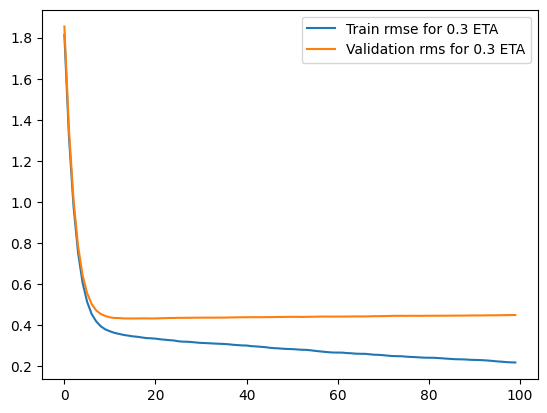

In [147]:
plt.plot(df_score.num_iter, df_score.train_rmse, label = 'Train rmse for 0.3 ETA')
plt.plot(df_score.num_iter, df_score.val_rmse, label = 'Validation rms for 0.3 ETA')
plt.legend()

In [151]:
key = 'eta=%s' %(xgb_params['eta'])

scores[key] = parse_xgb_output(output)

In [152]:
scores

{'eta=0.3':     num_iter  train_rmse  val_rmse
 0          0     1.81393   1.85444
 1          1     1.31919   1.35353
 2          2     0.98120   1.01316
 3          3     0.75443   0.78667
 4          4     0.60680   0.64318
 ..       ...         ...       ...
 95        95     0.22475   0.44904
 96        96     0.22336   0.44954
 97        97     0.22131   0.44979
 98        98     0.22013   0.45040
 99        99     0.21950   0.45018
 
 [100 rows x 3 columns],
 'eta=0.1':     num_iter  train_rmse  val_rmse
 0          0     2.28944   2.34561
 1          1     2.07396   2.12434
 2          2     1.88066   1.92597
 3          3     1.70730   1.74987
 4          4     1.55163   1.59059
 ..       ...         ...       ...
 95        95     0.30625   0.42611
 96        96     0.30565   0.42621
 97        97     0.30557   0.42629
 98        98     0.30486   0.42629
 99        99     0.30419   0.42623
 
 [100 rows x 3 columns]}

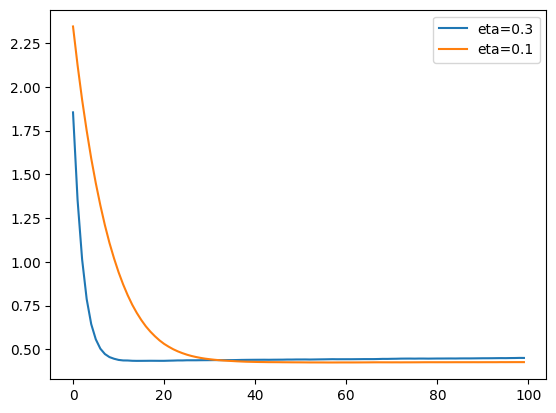

In [155]:
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_rmse, label=key)
plt.legend()

In [ ]:
# Learning rate of 0.1 is better as it gradually improves the rmse